notebook for MXNet visualization, tested on Python 3.6 (Win 10 lokal and Deep Learning AMI Amazon Linux)

In [1]:
import mxnet as mx
import mxnet.notebook.callback
import numpy as np
import os
import operator
import logging
#import urllib         # for Python 2
import urllib.request  # for Python 3
import gzip
import struct
import math
import cv2
import scipy.misc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage.transform

In [2]:
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    
    if force_download or not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)
        
    return fname


def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32) / 255


def read_Fashion_MNIST_data_compact(label, image):
    base_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/'
    
    with gzip.open(download_data(base_url + label, False)) as flbl:
        flbl.read(8)
        label = np.fromstring(flbl.read(), dtype=np.int8)
        
    with gzip.open(download_data(base_url + image, False), 'rb') as fimg:
        # will look up "struct.unpack" later
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
        
    return (label, image)

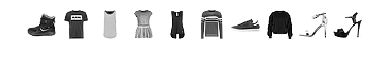

labels: [9 0 0 3 0 2 7 2 5 5]
('Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal')


In [3]:
(train_lbl, train_img) = read_Fashion_MNIST_data_compact('train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz')
(val_lbl, val_img)     = read_Fashion_MNIST_data_compact('t10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz')


fashion_labels=['T-shirt/top','Trouser','Pullover','Dress','Coat',
                'Sandal','Shirt','Sneaker','Bag','Ankle boot']


pict_number = 10

for i in range(pict_number):
    plt.subplot(1,pict_number,i+1)
    dsp_img= train_img[i]
    plt.imshow(dsp_img, cmap='Greys')
    plt.axis('off')

plt.show()


print('labels: %s' % (train_lbl[0:pict_number],))
print(operator.itemgetter(*train_lbl[0:pict_number])(fashion_labels))


In [4]:
batch_size = 100

train_data_iter = mx.io.NDArrayIter(data = {'fashion_data': to4d(train_img)}, label = {'fashion_item_label': train_lbl}, batch_size = batch_size, shuffle=True)
test_data_iter = mx.io.NDArrayIter(data = {'fashion_data': to4d(val_img)}, label = {'fashion_item_label': val_lbl}, batch_size = batch_size)


# fashion_item_label = mx.sym.Variable('fashion_item_label')
fashion_item_label = mx.symbol.Variable('fashion_item_label')

# input
data = mx.symbol.Variable('fashion_data')

# Flatten the data from 4-D shape into 2-D (batch_size, num_channel*width*height)
data = mx.sym.flatten(data = data, name = 'flatten')


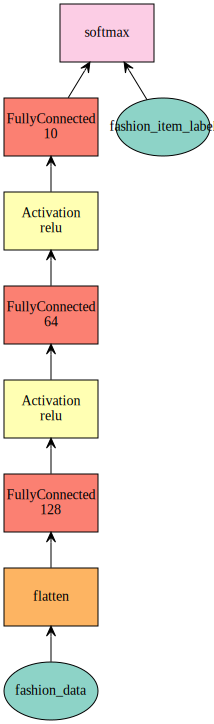

In [5]:
# 1st fully-connected layer + activation function
fc1  = mx.sym.FullyConnected(data = data, num_hidden = 128)
act1 = mx.sym.Activation(data = fc1, act_type = "relu")

# 2nd fully-connected layer + activation function
fc2  = mx.sym.FullyConnected(data = act1, num_hidden = 64)
act2 = mx.sym.Activation(data = fc2, act_type = "relu")

# 3rd fully connected layer (MNIST uses 10 classes)
fc3  = mx.sym.FullyConnected(data = act2, num_hidden = 10)

# softmax with cross entropy loss
mlp  = mx.sym.SoftmaxOutput(data = fc3, label = fashion_item_label, name = 'softmax')

mx.viz.plot_network(mlp)


In [6]:
logging.basicConfig(level = logging.INFO)
logging.getLogger().setLevel(logging.INFO)

ctx = mx.cpu()  # for GPU change to mx.gpu()

mod = mx.mod.Module(symbol = mlp, data_names = ['fashion_data'], label_names = ['fashion_item_label'], context = ctx, logger = logging)

num_epoch_current = 20

mod.fit(train_data_iter,                              # train data
        eval_data = test_data_iter,                   # validation data
        optimizer ='sgd',                             # use SGD to train
        optimizer_params = {'learning_rate' : 0.1},   # use fixed learning rate
        eval_metric = mx.metric.Accuracy(),           # report accuracy during training
        num_epoch = num_epoch_current,                # train for at most 10 dataset passes
        epoch_end_callback = mx.callback.do_checkpoint('fashion_mnist'),
        force_rebind = True,
        force_init = True)


INFO:root:Epoch[0] Train-accuracy=0.285783
INFO:root:Epoch[0] Time cost=1.531
INFO:root:Saved checkpoint to "fashion_mnist-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.519100
INFO:root:Epoch[1] Train-accuracy=0.694183
INFO:root:Epoch[1] Time cost=1.552
INFO:root:Saved checkpoint to "fashion_mnist-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.768500
INFO:root:Epoch[2] Train-accuracy=0.792300
INFO:root:Epoch[2] Time cost=1.527
INFO:root:Saved checkpoint to "fashion_mnist-0003.params"
INFO:root:Epoch[2] Validation-accuracy=0.814800
INFO:root:Epoch[3] Train-accuracy=0.828633
INFO:root:Epoch[3] Time cost=1.554
INFO:root:Saved checkpoint to "fashion_mnist-0004.params"
INFO:root:Epoch[3] Validation-accuracy=0.829300
INFO:root:Epoch[4] Train-accuracy=0.844700
INFO:root:Epoch[4] Time cost=1.542
INFO:root:Saved checkpoint to "fashion_mnist-0005.params"
INFO:root:Epoch[4] Validation-accuracy=0.841200
INFO:root:Epoch[5] Train-accuracy=0.856683
INFO:root:Epoch[5] Time cost=1.515
IN

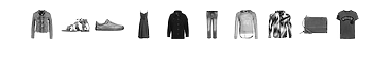

Predicted fashion label for image 10 is 4 (Coat)
Predicted fashion label for image 11 is 5 (Sandal)
Predicted fashion label for image 12 is 5 (Sandal)
Predicted fashion label for image 13 is 3 (Dress)
Predicted fashion label for image 14 is 4 (Coat)
Predicted fashion label for image 15 is 1 (Trouser)
Predicted fashion label for image 16 is 2 (Pullover)
Predicted fashion label for image 17 is 2 (Pullover)
Predicted fashion label for image 18 is 8 (Bag)
Predicted fashion label for image 19 is 0 (T-shirt/top)


In [7]:
pred_data_iter = mx.io.NDArrayIter(data = {'fashion_data': to4d(val_img)[0:100]}, batch_size = batch_size)
pred_digits    = mod.predict(eval_data = pred_data_iter).asnumpy()

pred_start  = 10
# number of items we want to predict
pred_number = 10

for i in range(pred_number):
    plt.subplot(1, pred_number, i + 1)
    plt.imshow(val_img[i + pred_start], cmap='Greys')
    plt.axis('off')

plt.show()

for x in range(pred_start, pred_start + pred_number):
    label = np.where(pred_digits[x] == pred_digits[x].max())[0][0]
    print("Predicted fashion label for image %s is %s (%s)" % (x, label, fashion_labels[label]))


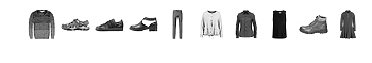

Predicted fashion label for image 20 is 2 (Pullover)
Predicted fashion label for image 21 is 5 (Sandal)
Predicted fashion label for image 22 is 7 (Sneaker)
Predicted fashion label for image 23 is 5 (Sandal)
Predicted fashion label for image 24 is 1 (Trouser)
Predicted fashion label for image 25 is 2 (Pullover)
Predicted fashion label for image 26 is 6 (Shirt)
Predicted fashion label for image 27 is 0 (T-shirt/top)
Predicted fashion label for image 28 is 9 (Ankle boot)
Predicted fashion label for image 29 is 3 (Dress)


In [8]:
pred_start  = 20
# number of items we want to predict
pred_number = 10

for i in range(pred_number):
    plt.subplot(1, pred_number, i + 1)
    plt.imshow(val_img[i + pred_start], cmap='Greys')
    plt.axis('off')

plt.show()

for x in range(pred_start, pred_start + pred_number):
    label = np.where(pred_digits[x] == pred_digits[x].max())[0][0]
    print("Predicted fashion label for image %s is %s (%s)" % (x, label, fashion_labels[label]))

In [9]:
urllib.request.urlretrieve('https://images-na.ssl-images-amazon.com/images/I/81OaXwn1x4L._UX679_.jpg', 'predict1.jpg')
urllib.request.urlretrieve('https://images-eu.ssl-images-amazon.com/images/I/31TcgNHsbIL._AC_UL260_SR200,260_.jpg', 'predict2.jpg')
urllib.request.urlretrieve('https://images-eu.ssl-images-amazon.com/images/I/41hWhZBIc3L._AC_UL260_SR200,260_.jpg', 'predict3.jpg')


('predict3.jpg', <http.client.HTTPMessage at 0x7fef5b6d9940>)

In [10]:
# prediction_model_check_point = 10
prediction_model_check_point = 20
prediction_model_prefix      = 'fashion_mnist'

prediction_sym, arg_params, aux_params = mx.model.load_checkpoint(prediction_model_prefix, prediction_model_check_point)
prediction_model = mx.mod.Module(symbol = prediction_sym, data_names = ['fashion_data'], label_names = ['fashion_item_label'])

prediction_model.bind(for_training = False, data_shapes = [('fashion_data', (1,1,28,28))], label_shapes = [('fashion_item_label', (1,))])
prediction_model.set_params(arg_params = arg_params, aux_params = aux_params, allow_missing = True)
